In [21]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.spatial.distance import cdist

In [22]:
customers_df = pd.read_csv('datasets/customers.csv')
customers_df.head()

,Unnamed: 0,OS,ISP,Age,DateTime,Time_Spent
0,0,Android,Cox,29,2022-02-23 20:01:32,27.547
1,1,iOS,Xfinity,30,2022-04-20 20:01:32,27.547
2,2,iOS,HughesNet,33,2022-02-16 20:01:32,27.547
3,3,Android,AT&T,26,2022-02-16 20:01:32,27.547
4,4,Android,AT&T,25,2022-02-16 20:01:32,27.547


In [23]:
#Validating null values
customers_df.isnull().sum()

Unnamed: 0    0
OS            0
ISP           0
Age           0
DateTime      0
Time_Spent    0
dtype: int64

In [24]:
#Validating max amd min values
print(customers_df.describe())

       Unnamed: 0        Age  Time_Spent
count    6.000000   6.000000       6.000
mean     2.500000  27.833333      27.547
std      1.870829   3.430258       0.000
min      0.000000  24.000000      27.547
25%      1.250000  25.250000      27.547
50%      2.500000  27.500000      27.547
75%      3.750000  29.750000      27.547
max      5.000000  33.000000      27.547


In [25]:
#Drop not numerical columns - Preparing data for Kmeans
customers_kmeans_df = customers_df.drop(['Unnamed: 0', 'OS', 'ISP', 'DateTime'], axis=1)
customers_kmeans = customers_kmeans_df.values

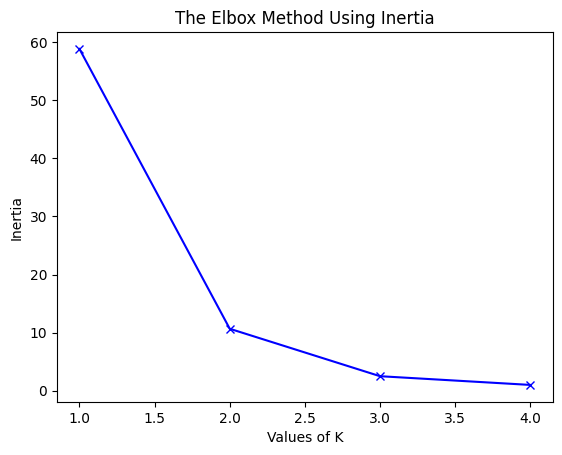

In [26]:
#Elbow curve to find optimal K
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1,5)

for k in K:
    #Building and fitting the model
    kmean_model = KMeans(n_clusters=k).fit(customers_kmeans)
    
    sum_cdist = sum(np.min(cdist(customers_kmeans, kmean_model.cluster_centers_, 'euclidean'), axis=1)) / customers_kmeans.shape[0]
    inertia = kmean_model.inertia_
    
    distortions.append(sum_cdist)    
    inertias.append(inertia)
    
    mapping1[k] = sum_cdist
    mapping2[k] = inertia

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbox Method Using Inertia')
plt.show()

In [27]:
#Different scales are used for age and time_spent - We will use a standard scaler
standard_scaler = StandardScaler()

#Create KMeans model using optimal k value obtained from elbow method using inertia. k = 3
model_kmeans = KMeans(n_clusters=3)

#Create pipeline with model and scaler
pipeline_kmeans = make_pipeline(standard_scaler, model_kmeans)

#Fit and predict
pipeline_kmeans.fit(customers_kmeans)
labels_kmeans = pipeline_kmeans.predict(customers_kmeans)

print(model_kmeans.labels_)
print(model_kmeans.cluster_centers_)

[0 0 2 1 1 1]
[[ 0.5322463   0.        ]
 [-0.9048187   0.        ]
 [ 1.64996352  0.        ]]


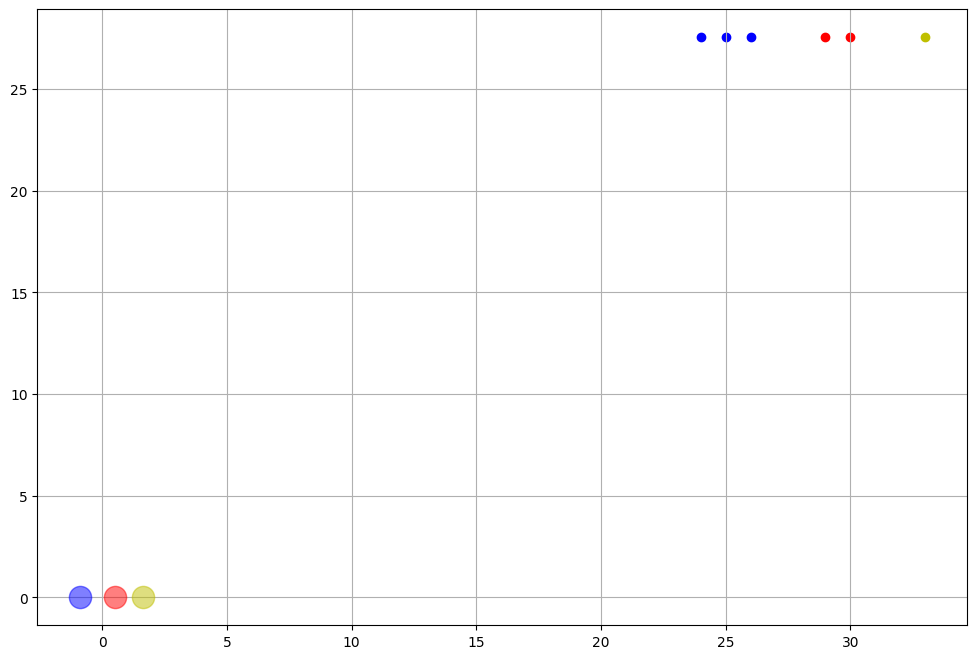

In [31]:
#Preparing data for plot
xs = customers_kmeans[:,0]
ys = customers_kmeans[:,1]

assignments = model_kmeans.labels_
cluster_classes = np.unique(assignments)

colors = ['r', 'b', 'y']
plt.figure(figsize=(12,8))

for s,_ in enumerate(cluster_classes):
    plt.scatter(xs[assignments==s], ys[assignments==s], c=colors[s])
    
plt.plot(model_kmeans.cluster_centers_[0][0], model_kmeans.cluster_centers_[0][1], 'ro', markersize=16, alpha=0.5)
plt.plot(model_kmeans.cluster_centers_[1][0], model_kmeans.cluster_centers_[1][1], 'bo', markersize=16, alpha=0.5)
plt.plot(model_kmeans.cluster_centers_[2][0], model_kmeans.cluster_centers_[2][1], 'yo', markersize=16, alpha=0.5)
plt.grid()

In [32]:
print(model_kmeans.cluster_centers_)

[[ 0.5322463   0.        ]
 [-0.9048187   0.        ]
 [ 1.64996352  0.        ]]


In [33]:
#Measuring clustering quality using inertia
print(model_kmeans.inertia_)

0.2549575070821529


In [35]:
#Prepare categorical data for KModes
customers_df["OS"] = customers_df["OS"].astype("category")
customers_df["ISP"] = customers_df["ISP"].astype("category")
customers_df["AgeCategory"] = pd.cut(x=customers_df["Age"], bins=4, labels=['Children','Young','Adult','Senior'])
customers_df["TimeSpentCategory"] = pd.cut(x=customers_df["Time_Spent"], bins=3, labels=['Short','Medium','Long'])

In [36]:
#Verify data types conversion
print(customers_df.dtypes)

Unnamed: 0              int64
OS                   category
ISP                  category
Age                     int64
DateTime               object
Time_Spent            float64
AgeCategory          category
TimeSpentCategory    category
dtype: object


In [38]:
#Review first records
print(customers_df.head(20))

   Unnamed: 0       OS        ISP  Age             DateTime  Time_Spent  \
0           0  Android        Cox   29  2022-02-23 20:01:32      27.547   
1           1      iOS    Xfinity   30  2022-04-20 20:01:32      27.547   
2           2      iOS  HughesNet   33  2022-02-16 20:01:32      27.547   
3           3  Android       AT&T   26  2022-02-16 20:01:32      27.547   
4           4  Android       AT&T   25  2022-02-16 20:01:32      27.547   
5           5  Android       AT&T   24  2022-02-16 20:01:32      27.547   

  AgeCategory TimeSpentCategory  
0       Adult            Medium  
1       Adult            Medium  
2      Senior            Medium  
3    Children            Medium  
4    Children            Medium  
5    Children            Medium  


In [41]:
#Drop numerical columns - Preparing data for KModes
customers_kmodes_df = customers_df.drop(['Unnamed: 0', 'Time_Spent', 'DateTime', 'Age'], axis=1)
customers_kmodes = customers_kmodes_df.values

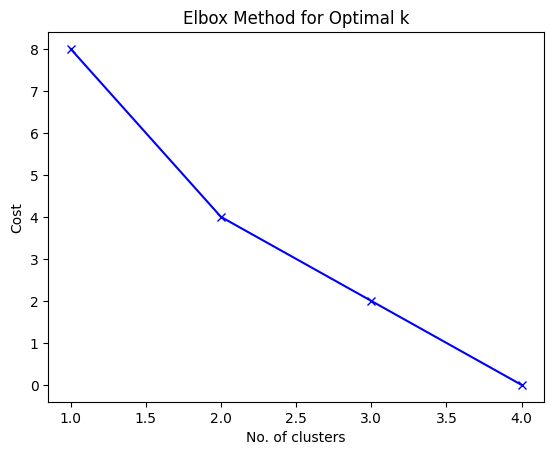

In [42]:
#Elbow curve to find optimal K
cost = []
K = range(1,5)
for k in list(K):
    kmode = KModes(n_clusters=k, init='Huang', n_init=5)
    kmode.fit_predict(customers_kmodes)
    cost.append(kmode.cost_)

plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbox Method for Optimal k')
plt.show()

In [43]:
#Create KModes model
model_kmodes = KModes(n_clusters=2, init='Huang', n_init=1)

#Fit and predict
labels_kmodes = model_kmodes.fit_predict(customers_kmodes)

print(model_kmodes.labels_)
print(model_kmodes.cluster_centroids_)

[1 1 0 0 0 0]
[['Android' 'AT&T' 'Children' 'Medium']
 ['Android' 'Cox' 'Adult' 'Medium']]


In [45]:
clusters_df = pd.DataFrame(labels_kmodes)
clusters_df.columns = ['cluster_predicted']
combined_df = pd.concat([customers_kmodes_df, clusters_df], axis=1).reset_index()
combined_df.head()

,index,OS,ISP,AgeCategory,TimeSpentCategory,cluster_predicted
0,0,Android,Cox,Adult,Medium,1
1,1,iOS,Xfinity,Adult,Medium,1
2,2,iOS,HughesNet,Senior,Medium,0
3,3,Android,AT&T,Children,Medium,0
4,4,Android,AT&T,Children,Medium,0


<AxesSubplot:xlabel='OS', ylabel='count'>

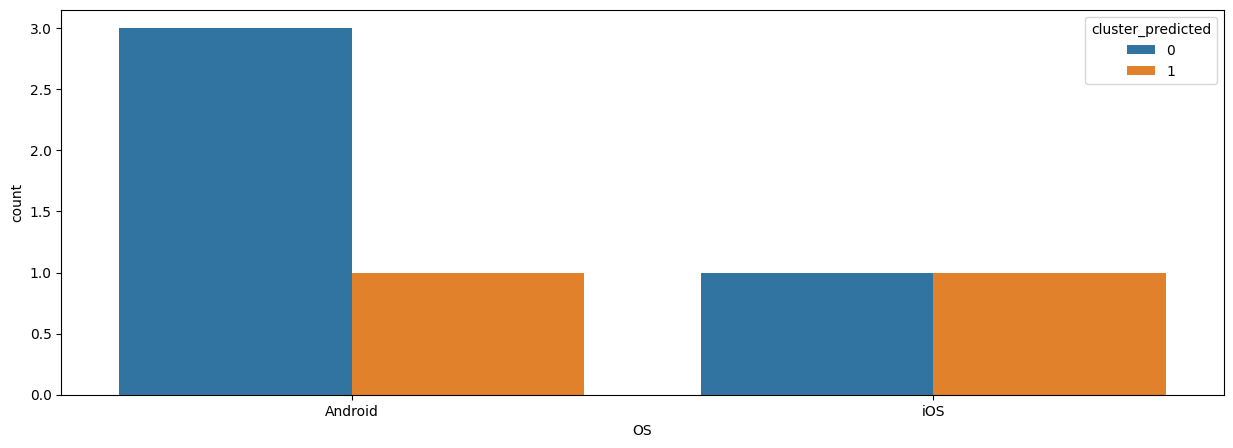

In [46]:
plt.subplots(figsize=(15,5))
sns.countplot(x=combined_df['OS'], order=combined_df['OS'].value_counts().index, hue=combined_df['cluster_predicted'])

<AxesSubplot:xlabel='ISP', ylabel='count'>

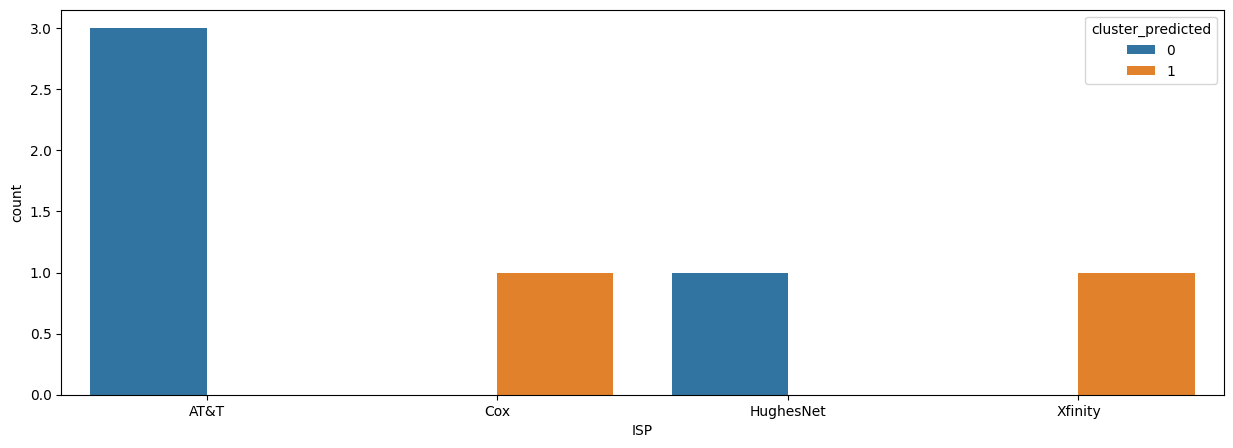

In [47]:
plt.subplots(figsize=(15,5))
sns.countplot(x=combined_df['ISP'], order=combined_df['ISP'].value_counts().index, hue=combined_df['cluster_predicted'])

<AxesSubplot:xlabel='AgeCategory', ylabel='count'>

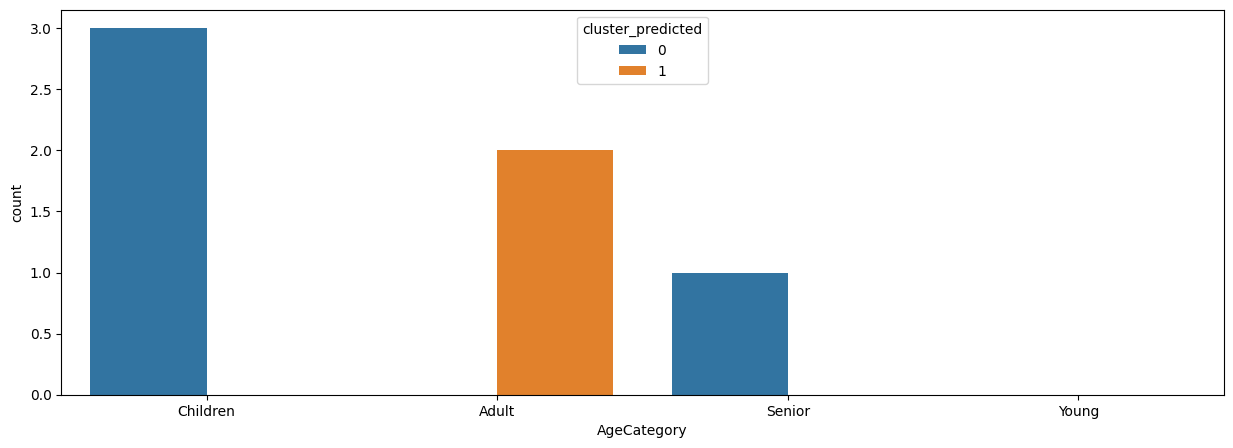

In [48]:
plt.subplots(figsize=(15,5))
sns.countplot(x=combined_df['AgeCategory'], order=combined_df['AgeCategory'].value_counts().index, hue=combined_df['cluster_predicted'])

<AxesSubplot:xlabel='TimeSpentCategory', ylabel='count'>

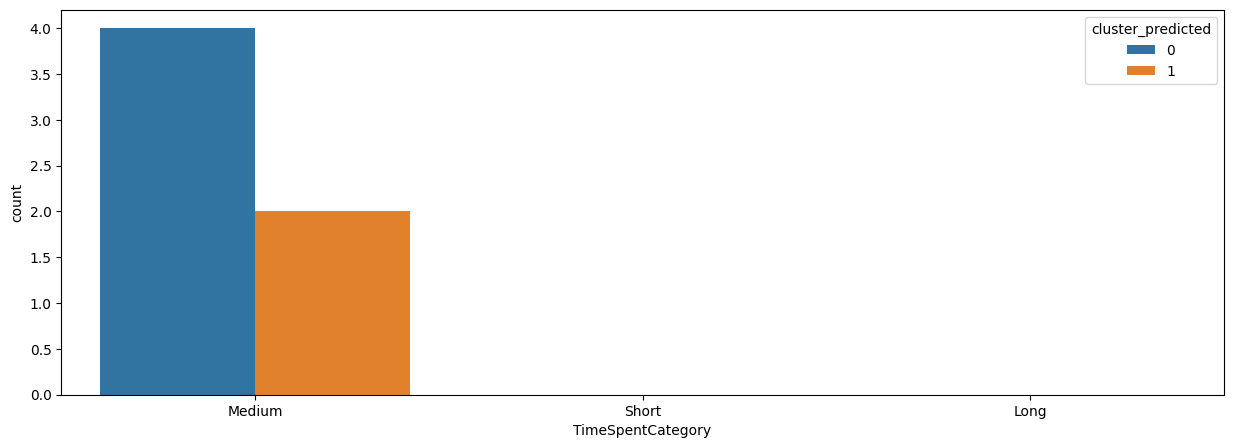

In [49]:
plt.subplots(figsize=(15,5))
sns.countplot(x=combined_df['TimeSpentCategory'], order=combined_df['TimeSpentCategory'].value_counts().index, hue=combined_df['cluster_predicted'])